In [1]:
import nibabel as nib
import os
from augmentation import *
import torch
import numpy as np
import random
import torch.nn.functional as F
from tqdm import tqdm
from pathlib import Path
import csv
import pandas as pd

mod1 = 'DWI_800.nii.gz'
mod2 = 'GED1.nii.gz'
mod3 = 'GED2.nii.gz'
mod4 = 'GED3.nii.gz'
mod5 = 'GED4.nii.gz'
mod6 = 'T1.nii.gz'
mod7 = 'T2.nii.gz'
mod8 = 'mask_GED4.nii.gz'

mods = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8]

vendor_to_number = {'A': 0, 'B1':1, 'B2':2, 'C':3}

In [2]:

# Define the path to the main folder
search_directory = Path('C://Users//SCoulY//Downloads//care2025_liver_biodreamer//data')

# Recursively find all files ending with '.nii.gz'
# The rglob('*.nii.gz') method returns a generator
mod_list = []
for mod in mods:
    file_list = list(search_directory.rglob(f'*{os.sep}{mod}'))
    mod_list.append(file_list)
    print(f"Mod {mod} found {len(file_list)} files.")

mask_list = []
search_dir = Path('C://Users//SCoulY//Downloads//care2025_liver_biodreamer//data//train_all_pred_masks')
for mask in search_dir.rglob('*.nii.gz'):
    mask_list.append(mask)
print(f"Found {len(mask_list)} segmentation masks.")

Mod DWI_800.nii.gz found 330 files.
Mod GED1.nii.gz found 358 files.
Mod GED2.nii.gz found 357 files.
Mod GED3.nii.gz found 354 files.
Mod GED4.nii.gz found 360 files.
Mod T1.nii.gz found 358 files.
Mod T2.nii.gz found 358 files.
Mod mask_GED4.nii.gz found 30 files.
Found 359 segmentation masks.


In [3]:
# pair the samples with segmentation masks
mask_str_list = [str(mask.parent).split(os.sep)[-1] + os.sep + mask.name for mask in mask_list]

mod_roi_list = []
for sample in tqdm(mod_list[4]): #only GED4
    mod_name = sample.name
    sample_name = str(sample.parent).split(os.sep)[-1]  # Get the last part of the path as sample name
    # print(f"Processing sample: {sample_name} with mod: {mod_name}")
    mask_name = sample_name + os.sep + 'GED4_pred.nii.gz'  # Assuming mask corresponds to DWI_800
    
    if mask_name in mask_str_list:
        idx = mask_str_list.index(mask_name)
        mask = nib.load(mask_list[idx]).get_fdata().astype(np.float32)
        img = nib.load(str(sample).replace(mod_name, 'GED4.nii.gz')).get_fdata().astype(np.float32)
        roi = img[mask>0]
        if roi.size == 0:
            print(f"No ROI found for sample: {sample_name} with mod: {mod_name}")
            continue
        mod_roi_list.append((img, mask, roi, sample_name))


        


100%|██████████| 360/360 [02:21<00:00,  2.54it/s]


In [ ]:
import gc
gc.collect()
#calculate morphology features for each ROI
from skimage import measure, morphology
import pandas as pd
import math
from scipy.spatial import ConvexHull
from scipy.stats import skew, kurtosis
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.feature import structure_tensor, structure_tensor_eigenvalues
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

def compute_surface_area(binary_mask):
    """Compute surface area of a 3D binary mask using marching cubes."""
    verts, faces, _, _ = measure.marching_cubes(binary_mask, level=0)
    area = 0.0
    for tri in faces:
        p0, p1, p2 = verts[tri]
        tri_area = 0.5 * np.linalg.norm(np.cross(p1 - p0, p2 - p0))
        area += tri_area
    return area, verts

def compute_convex_volume(verts):
    """Compute convex hull volume from vertices."""
    try:
        hull = ConvexHull(verts)
        return hull.volume
    except:
        return np.nan

def compute_directional_glcm_features(img_3d, mask_3d, distances=[1], levels=256):
    """Compute simple directional GLCM contrast on three orthogonal slices through ROI."""
    # Take central slices through the ROI
    coords = np.array(np.where(mask_3d))
    zc, yc, xc = [int(np.mean(c)) for c in coords]

    features = {}

    # Helper to compute contrast per angle in 2D
    def glcm_contrast(slice2d):
        # quantize
        img = slice2d.astype(np.uint8)
        glcm = graycomatrix(img, distances=distances, angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=levels, symmetric=True, normed=True)
        contrast = [graycoprops(glcm, 'contrast')[0, i] for i in range(4)]
        return contrast

    # XY slice
    contrast_xy = glcm_contrast(img_3d[zc])
    features['glcm_xy_contrast_mean'] = np.mean(contrast_xy)
    features['glcm_xy_anisotropy'] = (max(contrast_xy) - min(contrast_xy)) / (np.mean(contrast_xy)+1e-8)

    # XZ slice
    contrast_xz = glcm_contrast(img_3d[:, yc, :])
    features['glcm_xz_contrast_mean'] = np.mean(contrast_xz)
    features['glcm_xz_anisotropy'] = (max(contrast_xz) - min(contrast_xz)) / (np.mean(contrast_xz)+1e-8)

    # YZ slice
    contrast_yz = glcm_contrast(img_3d[:, :, xc])
    features['glcm_yz_contrast_mean'] = np.mean(contrast_yz)
    features['glcm_yz_anisotropy'] = (max(contrast_yz) - min(contrast_yz)) / (np.mean(contrast_yz)+1e-8)

    return features

def extract_features_with_intensity_gradient(mask_3d, img_3d):
    mask_3d = mask_3d.astype(bool)
    props = measure.regionprops(mask_3d.astype(np.uint8), intensity_image=img_3d)
    
    # precompute gradients
    gx, gy, gz = np.gradient(img_3d.astype(np.float32))
    grad_mag = np.sqrt(gx**2 + gy**2 + gz**2)

    # structure tensor
    A_elems = structure_tensor(img_3d, sigma=1)
    l1, l2, l3 = structure_tensor_eigenvalues(A_elems)
    # coherence: (λ1 - λ2) / (λ1 + λ2) for the two largest
    coherence_map = (l1 - l2) / (l1 + l2 + 1e-8)

    # Hessian
    H_elems = hessian_matrix(img_3d, sigma=1, order='rc')
    h_eigs = hessian_matrix_eigvals(H_elems)  # returns sorted eigenvalues
    h_eigs = np.stack(h_eigs, axis=-1)  # shape (Z,Y,X,3)
    # simple anisotropy ratio: |λ1| / (|λ2|+|λ3|)
    h_aniso = np.abs(h_eigs[..., 0]) / (np.abs(h_eigs[..., 1]) + np.abs(h_eigs[..., 2]) + 1e-8)

    # anisotropy maps
    coherence_vals = coherence_map[mask_3d]
    mean_coherence = np.mean(coherence_vals)
    std_coherence = np.std(coherence_vals)

    h_aniso_vals = h_aniso[mask_3d]
    mean_h_aniso = np.mean(h_aniso_vals)
    std_h_aniso = np.std(h_aniso_vals)

    # directional GLCM
    glcm_feats = compute_directional_glcm_features(img_3d, mask_3d)


    feature_list = []

    for region in props:
        volume = region.area

        # geometric features
        surf_area, verts = compute_surface_area(mask_3d)
        sphericity = (np.pi**(1/3) * (6 * volume)**(2/3)) / surf_area if surf_area > 0 else np.nan
        convex_volume = compute_convex_volume(verts)
        solidity = volume / convex_volume if convex_volume and convex_volume > 0 else np.nan
        inertia = region.inertia_tensor
        eigvals, _ = np.linalg.eigh(inertia)
        elongation = np.sqrt(eigvals.min() / eigvals.max()) if eigvals.max() > 0 else np.nan

        # intensity features
        intensities = img_3d[mask_3d]
        mean_int = np.mean(intensities)
        std_int = np.std(intensities)
        min_int = np.min(intensities)
        max_int = np.max(intensities)
        med_int = np.median(intensities)
        skew_int = skew(intensities, bias=False)
        kurt_int = kurtosis(intensities, bias=False)

        # gradient-based features
        grad_vals = grad_mag[mask_3d]
        mean_grad = np.mean(grad_vals)
        std_grad = np.std(grad_vals)
        min_grad = np.min(grad_vals)
        max_grad = np.max(grad_vals)
        med_grad = np.median(grad_vals)
        skew_grad = skew(grad_vals, bias=False)
        kurt_grad = kurtosis(grad_vals, bias=False)

        vol_portion = np.sum(mask_3d) / np.prod(mask_3d.shape)

        feature_list.append({
            "label": region.label,
            # morphology
            "volume_voxels": volume,
            "vol_portion": vol_portion,
            "surface_area": surf_area,
            "sphericity": sphericity,
            "convex_volume": convex_volume,
            "solidity": solidity,
            "elongation": elongation,
            # intensity
            "intensity_mean": mean_int,
            "intensity_std": std_int,
            "intensity_min": min_int,
            "intensity_max": max_int,
            "intensity_median": med_int,
            "intensity_skew": skew_int,
            "intensity_kurtosis": kurt_int,
            # gradient
            "grad_mean": mean_grad,
            "grad_std": std_grad,
            "grad_min": min_grad,
            "grad_max": max_grad,
            "grad_median": med_grad,
            "grad_skew": skew_grad,
            "grad_kurtosis": kurt_grad,
            # anisotropy
            "coherence_mean": mean_coherence,
            "coherence_std": std_coherence,
            "hessian_aniso_mean": mean_h_aniso,
            "hessian_aniso_std": std_h_aniso,
        })
        feature_list[0].update(glcm_feats)
    return pd.DataFrame(feature_list)

label_dic={'S1': 0, 'S2': 1, 'S3': 2, 'S4': 3}

csv_filename = "train_all_data.csv"
header_written = False 
with open(csv_filename, mode='w', newline='') as csvfile:
    writer = None
    for img, mask, roi, sample_name in tqdm(mod_roi_list):
        mask = mask.astype(np.uint8)
        vendor = sample_name.split('-')[1]
        vendor_number = vendor_to_number.get(vendor, -1)
        df = extract_features_with_intensity_gradient(mask, img)
        label = label_dic[sample_name.split('-')[-1]]
        df['label'] = label
        df['vendor'] = vendor_number
        if not header_written:
            writer = csv.DictWriter(csvfile, fieldnames=df.columns)
            writer.writeheader()
            header_written = True
        for _, row in df.iterrows():
            writer.writerow(row.to_dict())
        gc.collect()

print(f"{df.shape[0]} items written to {csv_filename}")


  0%|          | 0/359 [00:00<?, ?it/s]C:\Users\SCoulY\AppData\Local\Temp\ipykernel_2176\500675009.py:80: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(img_3d, sigma=1, order='rc')
  0%|          | 1/359 [00:27<2:44:49, 27.62s/it]C:\Users\SCoulY\AppData\Local\Temp\ipykernel_2176\500675009.py:80: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the current behavior
  H_elems = hessian_matrix(img_3d, sigma=1, order='rc')
  1%|          | 2/359 [01:01<3:07:31, 31.52s/it]C:\Users\SCoulY\AppData\Local\Temp\ipykernel_2176\500675009.py:80: FutureWarning: use_gaussian_derivatives currently defaults to False, but will change to True in a future version. Please specify this argument explicitly to maintain the curren

TypeError: object of type 'int' has no len()

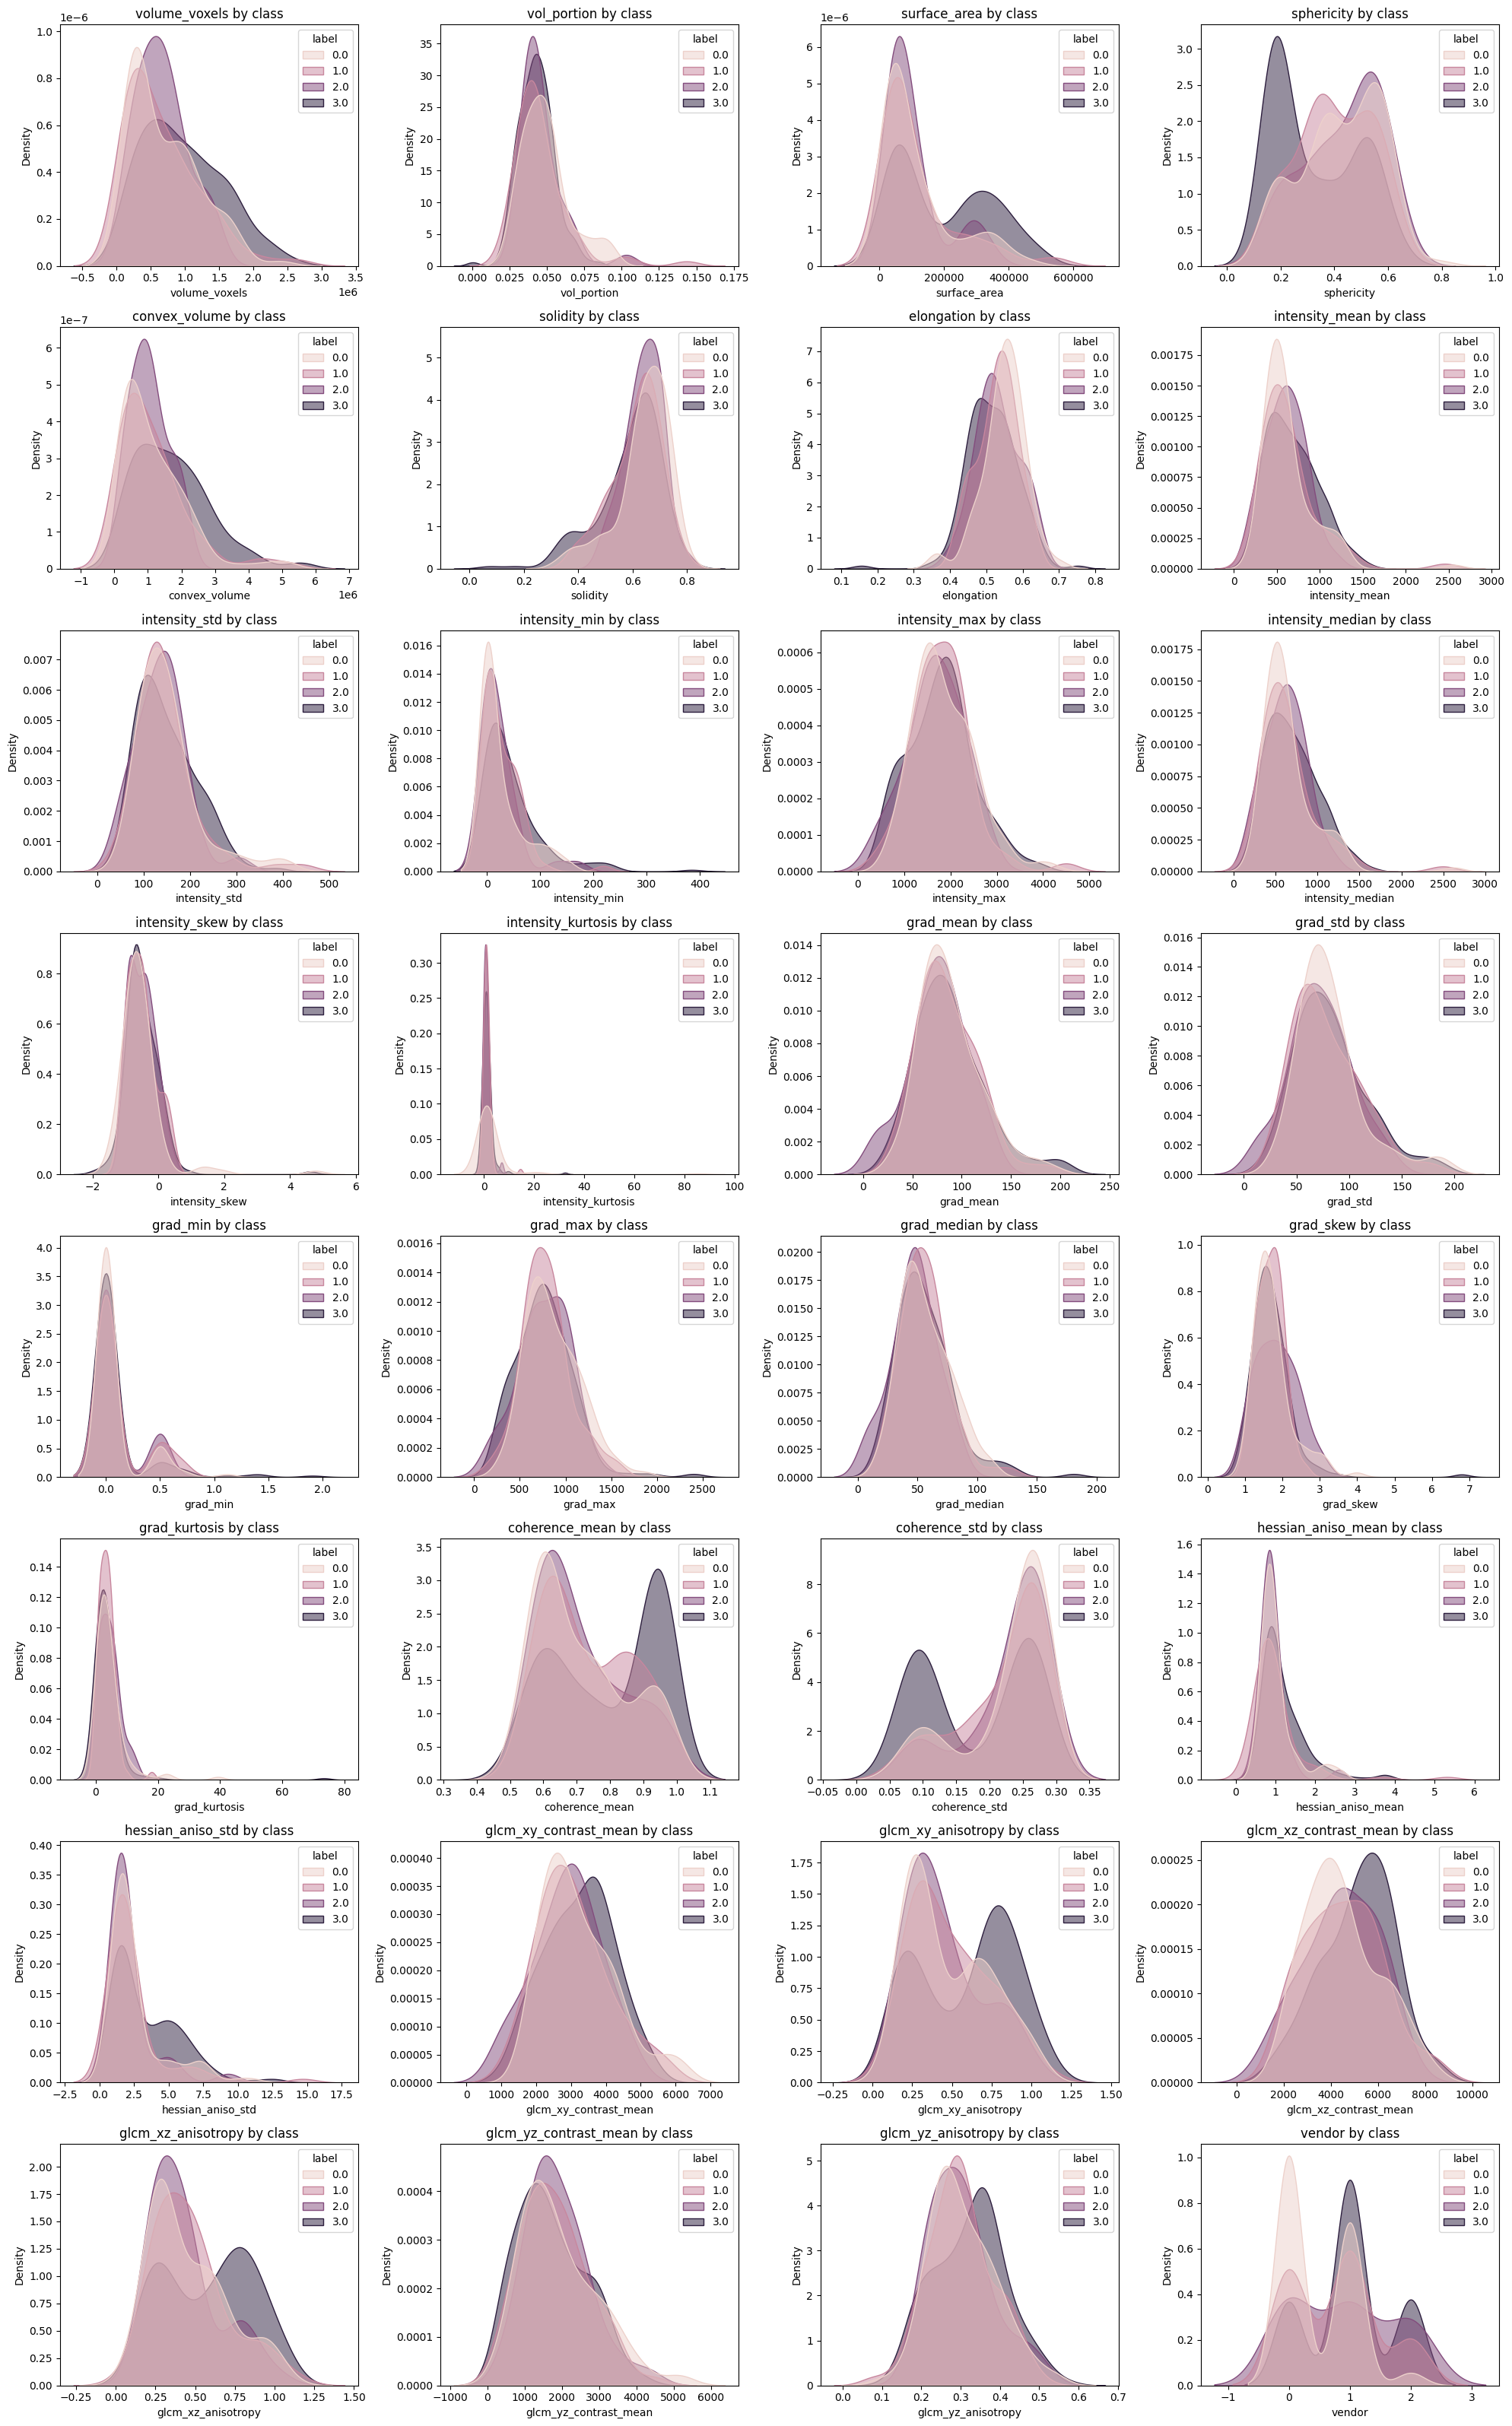

In [5]:
#plot feature distribution of each label
import seaborn as sns
import matplotlib.pyplot as plt

### read in the csv file
df_dataset = pd.read_csv('train_all_data.csv')

### Choose numerical features you want to plot
features_to_plot = df_dataset.columns.drop(['label']) # Exclude 'label' and 'bbox' column

### plot in all features in subplots

### Loop through each feature and plot distribution
# Plot all features in subplots for easier comparison
num_features = len(features_to_plot)
ncols = 4
nrows = int(np.ceil(num_features / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ax = axes[idx]
    sns.kdeplot(
        data=df_dataset,
        x=feature,
        hue="label",
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=ax
    )
    ax.set_title(f"{feature} by class")
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")

# Hide unused subplots
for j in range(idx+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
#built a classification model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import pandas as pd
from sklearn.metrics import classification_report


def train_classification_model(df, label_col='label'):
    """Train a Random Forest classifier on the dataset."""
    # Split features and labels
    print('df shape:', df.shape)
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight={0.0: 2, 1.0: 1, 2.0: 1, 3.0: 2})
    # model.fit(X_train, y_train)
    model.fit(X, y)
    # # calculate categorical accuracy
    y_pred = model.predict(X_test)
    # Calculate categorical accuracy for each class
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = report['accuracy']
    print(f"Classification Report:{report}")
    print(f"Overall accuracy: {accuracy:.4f}")
    return model, report


df_dataset = pd.read_csv('train_all_data.csv')
model, report = train_classification_model(df_dataset)

# Save the model with categorical accuracy in the filename
model_path = f'RF_{report["accuracy"]:.4f}_no_val.pkl'
joblib.dump(model, model_path)

df shape: (359, 33)
Classification Report:{'0.0': {'precision': 0.7142857142857143, 'recall': 0.5, 'f1-score': 0.5882352941176471, 'support': 20.0}, '1.0': {'precision': 0.25, 'recall': 0.15384615384615385, 'f1-score': 0.19047619047619047, 'support': 13.0}, '2.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}, '3.0': {'precision': 0.6, 'recall': 0.9090909090909091, 'f1-score': 0.7228915662650602, 'support': 33.0}, 'accuracy': 0.5833333333333334, 'macro avg': {'precision': 0.39107142857142857, 'recall': 0.39073426573426573, 'f1-score': 0.37540076271472445, 'support': 72.0}, 'weighted avg': {'precision': 0.5185515873015873, 'recall': 0.5833333333333334, 'f1-score': 0.5291155284068112, 'support': 72.0}}
Overall accuracy: 0.5833


c:\Users\SCoulY\Downloads\care2025_liver_biodreamer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\SCoulY\Downloads\care2025_liver_biodreamer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\SCoulY\Downloads\care2025_liver_biodreamer\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _war

['RF_0.5833_overweight_cls14.pkl']